In [61]:
import pandas as pd
from WindPy import *

def ema(data, n=12, val_name="close"):
    import numpy as np
    '''
        指数平均数指标 Exponential Moving Average
        Parameters
        ------
          data:pandas.DataFrame
                      通过 get_h_data 取得的数据
          n:int
                      移动平均线时长，时间单位根据data决定
          val_name:string
                      计算哪一列的列名，默认为 close 
        return
        -------
          EMA:numpy.ndarray<numpy.float64>
              指数平均数指标
    '''

    prices = []

    EMA = []

    for index, row in data.iterrows():
        if index == 0:
            past_ema = row[val_name]
            EMA.append(row[val_name])
        else:
            # Y=[2*X+(N-1)*Y’]/(N+1)
            today_ema = (2 * row[val_name] + (n - 1) * past_ema) / (n + 1)
            past_ema = today_ema

            EMA.append(today_ema)

    return np.asarray(EMA)


def macd(data, quick_n=12, slow_n=26, dem_n=9, val_name="close"):
    import numpy as np
    '''
        指数平滑异同平均线(MACD: Moving Average Convergence Divergence)
        Parameters
        ------
          data:pandas.DataFrame
                      通过 get_h_data 取得的
          quick_n:int
                      DIFF差离值中快速移动天数
          slow_n:int
                      DIFF差离值中慢速移动天数
          dem_n:int
                      DEM讯号线的移动天数
          val_name:string
                      计算哪一列的列名，默认为 close 
        return
        -------
          OSC:numpy.ndarray<numpy.float64>
              MACD bar / OSC 差值柱形图 DIFF - DEM
          DIFF:numpy.ndarray<numpy.float64>
              差离值
          DEM:numpy.ndarray<numpy.float64>
              讯号线
    '''

    ema_quick = np.asarray(ema(data, quick_n, val_name))
    ema_slow = np.asarray(ema(data, slow_n, val_name))
    DIFF = ema_quick - ema_slow
    data["diff"] = DIFF
    DEM = ema(data, dem_n, "diff")
    BAR = (DIFF - DEM)*2
    data['dem'] = DEM
    data['bar'] = BAR
    return  DIFF, DEM, BAR


STOCK_CODE='601127.SH'
df = pd.read_csv(f'./{STOCK_CODE}.csv')

df.columns
df.rename(columns={df.columns[0]:"date"}, inplace=True)
diff, dem ,bar = macd(df)
df
df.to_csv(f"{STOCK_CODE}_macd.csv")
buy_date = []
bar = df[['date', 'diff']]
bar

blue_bar_width = 6  # 绿柱子多少个才考虑买入


def scan_bar(bar, i):
    """
    打印绿柱缩短的第根日期
    返回下一个要遍历的df索引值
    """
    bar_size=bar.index.size

    end_i = i + blue_bar_width
    is_blue_bar_width_enough = (bar.loc[i:end_i, ['diff']] < 0).all()['diff']  # 绿色柱子宽度要足够，过滤掉零零星星不明显的绿柱子
    if is_blue_bar_width_enough:
        # 继续往后去找到全部的绿柱子，找到绿柱最大的索引，打印出来日期
        end_i += 1
        while (bar.loc[end_i:end_i, ['diff']] < 0).all().bool():
            end_i += 1
            if end_i >=bar_size:
                break
        # 开始扫描
        diff, date = bar.loc[i:end_i - 1, ['diff', 'date']].min()  # 负数找最小的（绿柱最长那个）
        print(date)

    else:  # 找到第一个大于等于0的bar点返回，然后从新开始scan
        end_i = i + 1
        while (bar.loc[end_i:end_i, ['diff']] < 0).all().bool():
            end_i += 1
            if end_i >=bar_size:
                break
    #         print(end_i)

    return end_i


def scan_blue_index(df):
    blue_index_range= [] #存放2元tuple， [start:end]

    # 第一步：先把全部blue bar index都放入一个数组
    blue_bar_temp_arr = []
    for i in range(0, df.index.size): #从第一个开始
        diff_val = df.loc[i:i,['bar']]['bar'].values[0]
        if diff_val<0:
            blue_bar_temp_arr.append(i)

    # 第二步：扫描连续的绿柱子做成[start_index, end_index]二元组

    # for i in range(0,len(blue_bar_temp_arr)):
    i=0
    while i < len(blue_bar_temp_arr):
        start_i = i
        end_i = i+1
        while end_i < len(blue_bar_temp_arr) and blue_bar_temp_arr[end_i-1]+1 == blue_bar_temp_arr[end_i]:
            end_i += 1

        blue_index_range.append((blue_bar_temp_arr[i], blue_bar_temp_arr[end_i-1]))
        i = end_i

    return blue_index_range








# for i,r in bar.iterrows():
#     date, diff=r
#     scan_bar(i, bar) # 从i开始向后扫描， 返回扫描终点下一个坐标

i = 0
print(f"index size= {bar.index.size}")
# while i < bar.index.size:
#     # row = bar.loc[i:i+1, bar.columns]
#     # i = scan_bar(bar, i)
#     # print(i)
#     pass

print("===================================")
blue_bar = scan_blue_index(df)
buy_dates = []
MIN_BLUE_AREA_WIDTH=6

for s, e in blue_bar:
    #print(f"{s}\t{e}")
    if e-s < MIN_BLUE_AREA_WIDTH:
        continue
    else:#把hi值，close取出来
        print(f"{s}\t{e}")
        df2 = df.loc[s:e, ['bar']]
        row_index = df[df.bar==df2.bar.min()].index[0]
        row = df.loc[row_index:row_index, ['date','close','open']]
        buy_row = df.loc[row_index+2:row_index+2, ['date','close','open']]
        print(buy_row['date'].values[0])
        buy_dates.append(buy_row['date'].values[0])


    





index size= 625
5	16
2019-01-04 11:00:00
51	58
2019-01-17 12:00:00
60	82
2019-01-23 14:00:00
92	103
2019-01-29 14:00:00
136	142
2019-02-18 11:00:00
158	164
2019-02-22 15:00:00
175	191
2019-03-01 15:00:00
212	218
2019-03-11 11:00:00
223	259
2019-03-14 15:00:00
275	288
2019-03-28 15:00:00
331	347
2019-04-16 14:00:00
360	390
2019-04-26 15:00:00
395	404
2019-05-07 10:00:00
462	471
2019-05-27 11:00:00
481	497
2019-06-03 11:00:00
568	590
2019-06-27 11:00:00
599	607
2019-07-03 15:00:00
615	624
2019-07-09 10:00:00


In [62]:
df

,date,close,high,open,low,diff,dem,bar
0,2019-01-02 10:00:00,16.66,17.00,17.00,16.64,0.000000,0.000000,0.000000
1,2019-01-02 11:00:00,16.65,16.71,16.66,16.61,-0.000798,-0.000160,-0.001276
2,2019-01-02 12:00:00,16.62,16.65,16.65,16.58,-0.003807,-0.000889,-0.005836
3,2019-01-02 14:00:00,16.70,16.80,16.62,16.60,0.000261,-0.000659,0.001840
4,2019-01-02 15:00:00,16.70,16.78,16.70,16.60,0.003445,0.000162,0.006566
5,2019-01-03 10:00:00,16.60,16.71,16.70,16.56,-0.002077,-0.000286,-0.003582
6,2019-01-03 11:00:00,16.13,16.68,16.58,16.08,-0.043873,-0.009003,-0.069739
7,2019-01-03 12:00:00,16.15,16.20,16.15,16.12,-0.074523,-0.022107,-0.104832
8,2019-01-03 14:00:00,16.04,16.17,16.16,16.00,-0.106463,-0.038978,-0.134968
9,2019-01-03 15:00:00,16.08,16.39,16.04,15.90,-0.127082,-0.056599,-0.140966


In [63]:
blue_bar
blue_bar_2 = []
for a,b in blue_bar:
    if b-a <MIN_BLUE_AREA_WIDTH:
        continue
    else:
        blue_bar_2.append((a,b))
        
blue_bar_2

[(5, 16),
 (51, 58),
 (60, 82),
 (92, 103),
 (136, 142),
 (158, 164),
 (175, 191),
 (212, 218),
 (223, 259),
 (275, 288),
 (331, 347),
 (360, 390),
 (395, 404),
 (462, 471),
 (481, 497),
 (568, 590),
 (599, 607),
 (615, 624)]

IndexError: index 0 is out of bounds for axis 0 with size 0

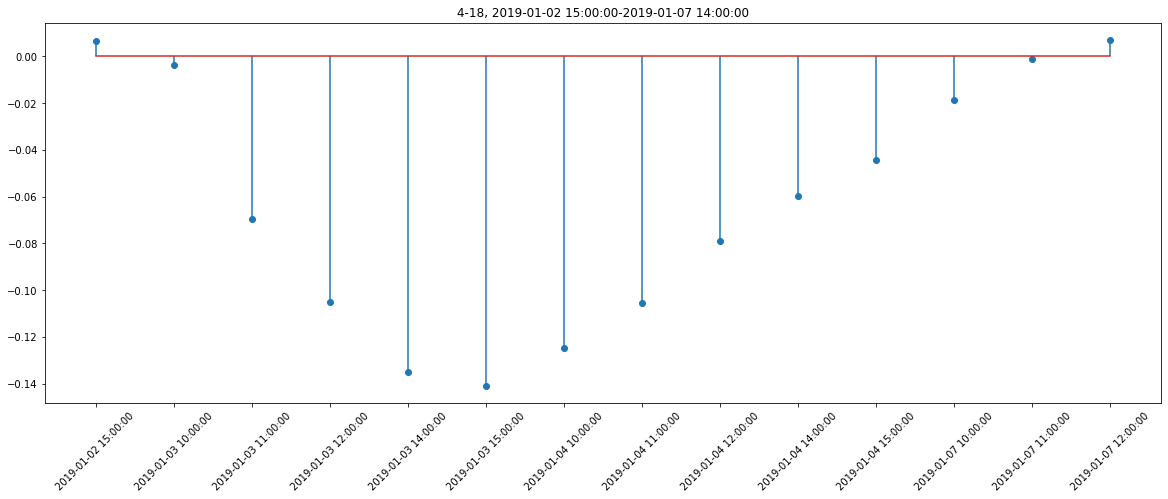

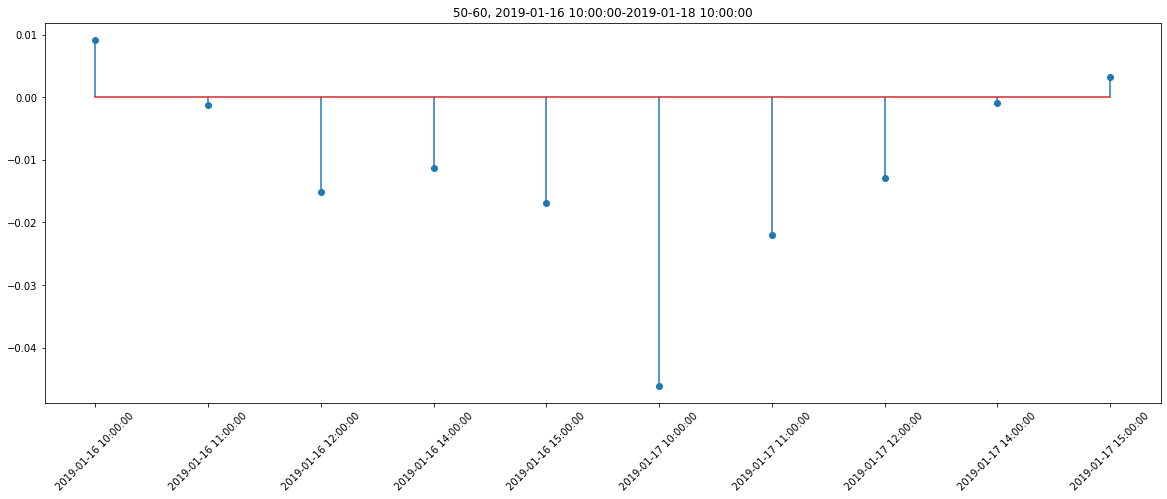

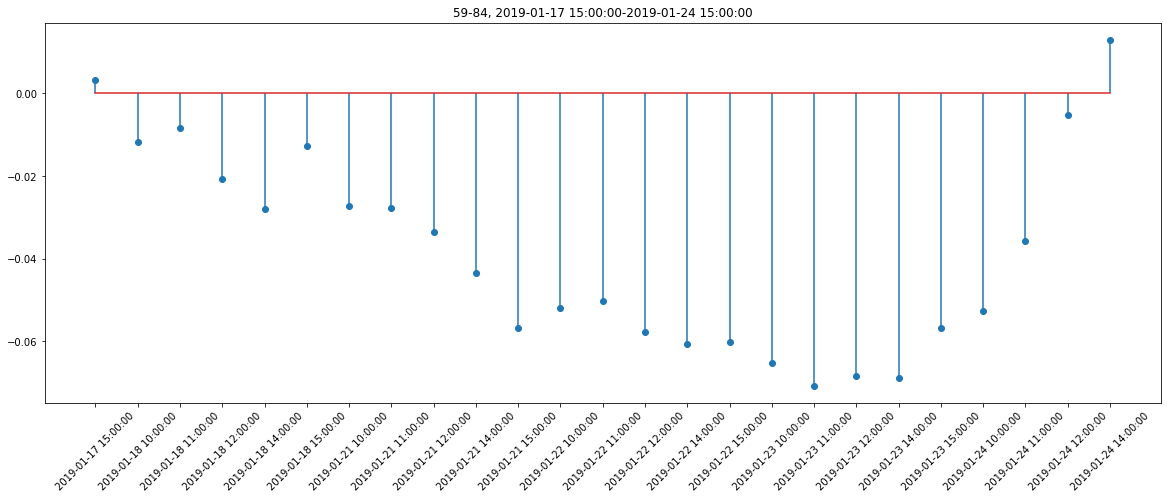

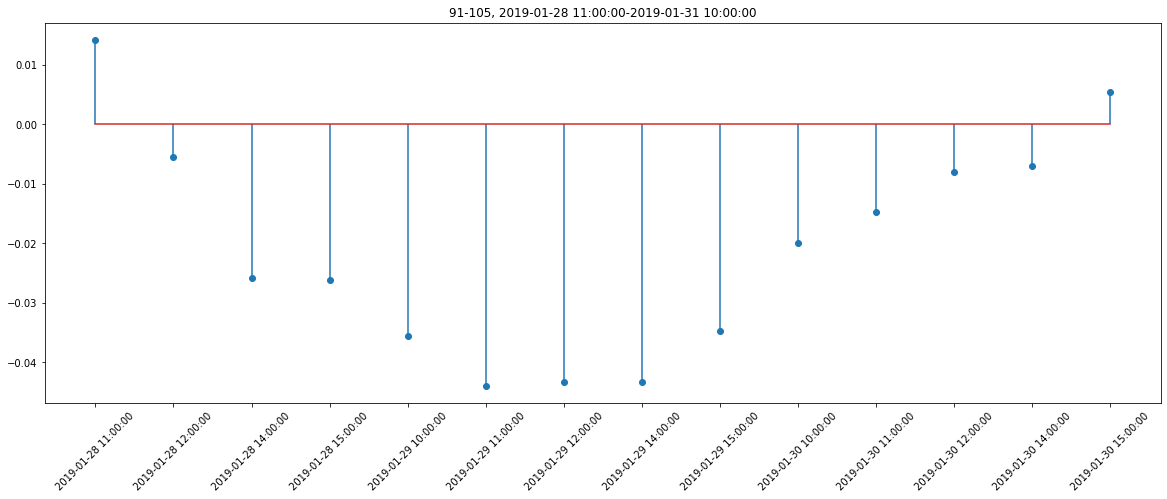

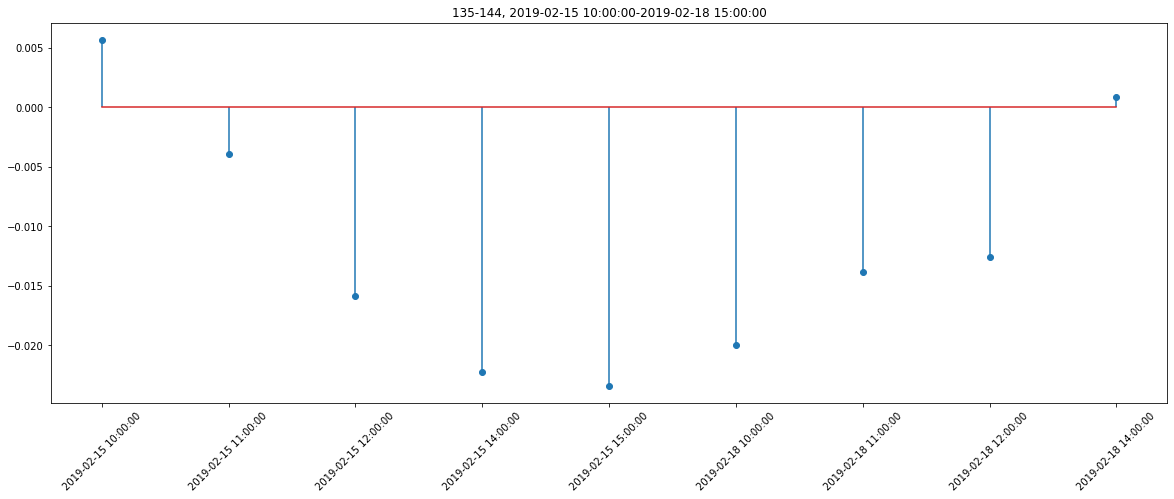

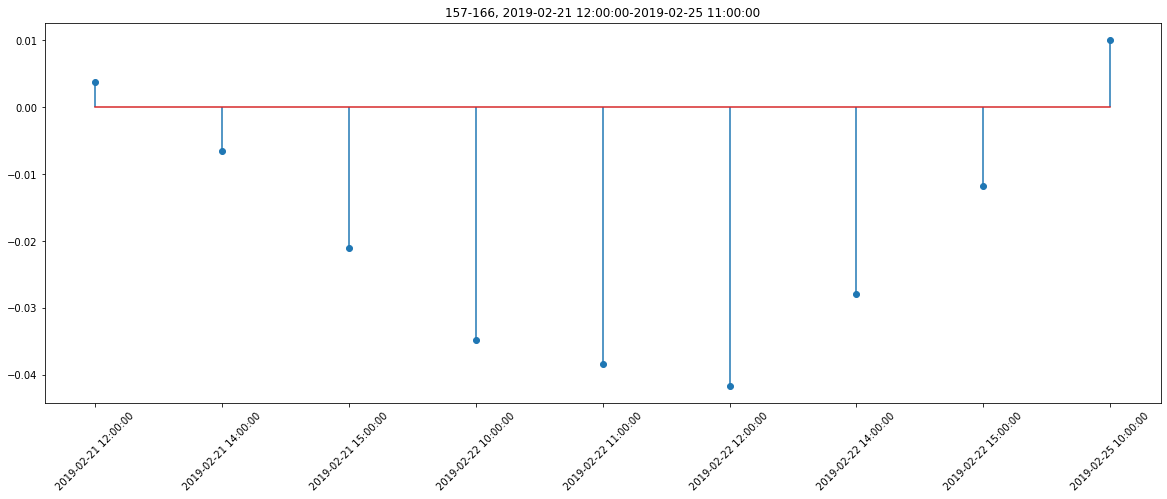

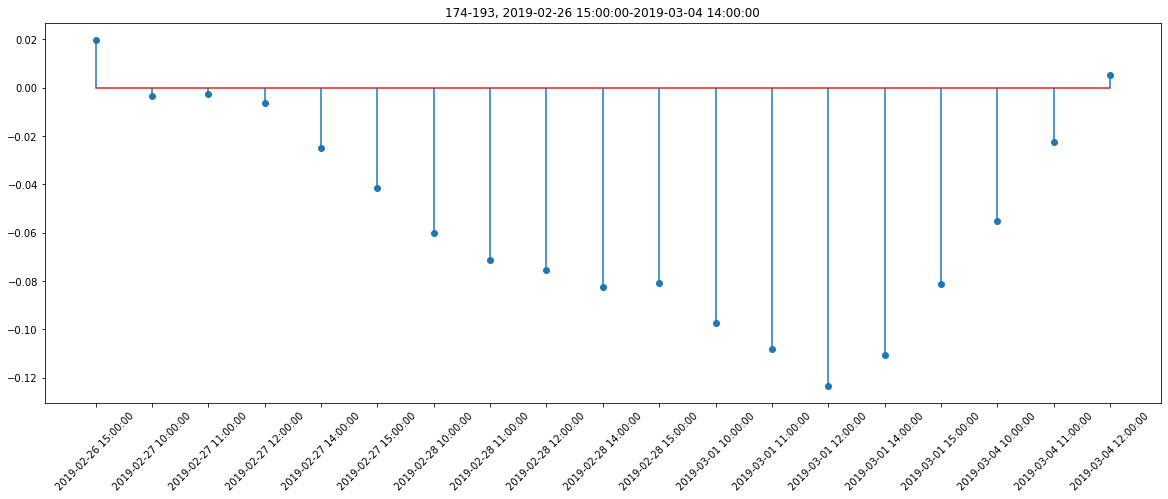

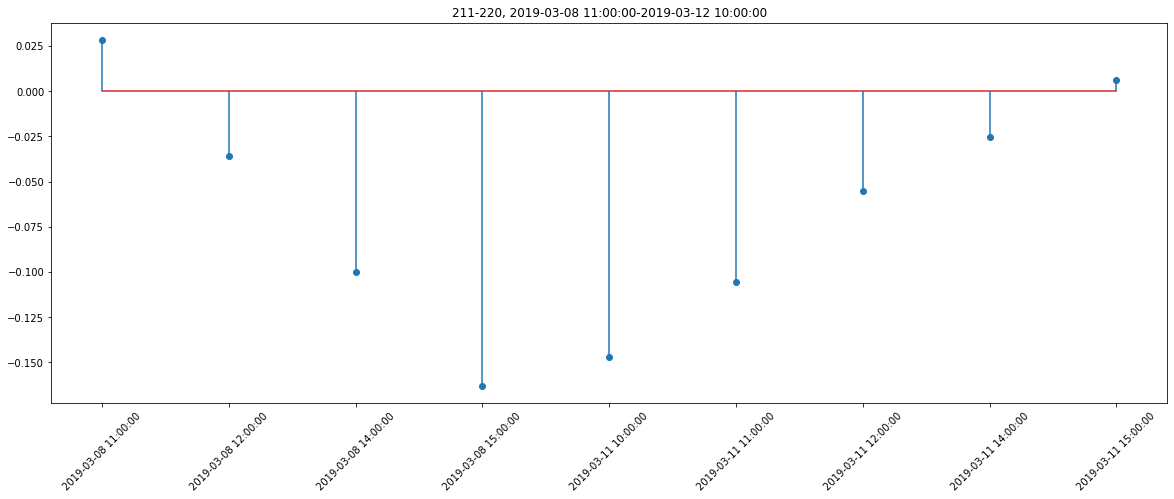

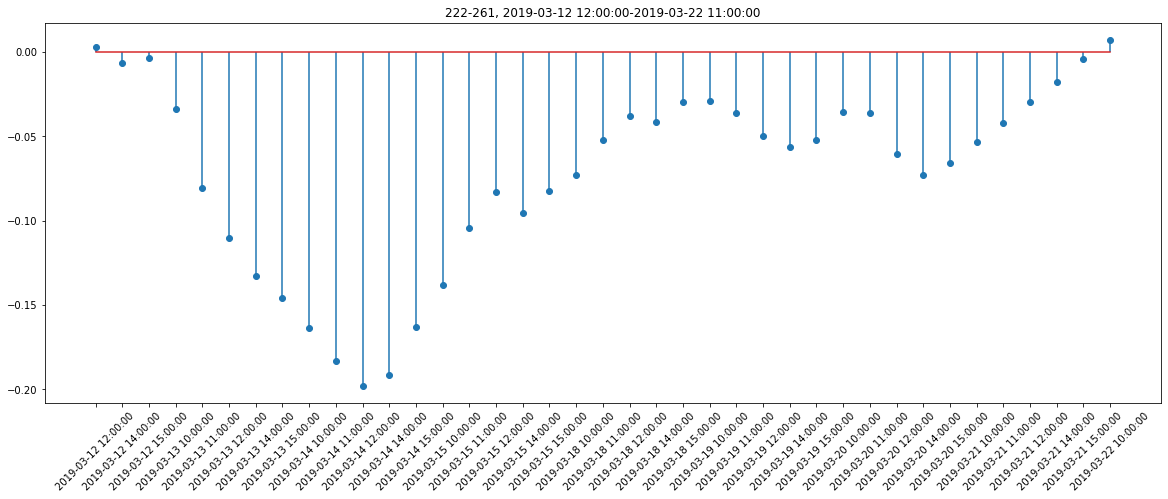

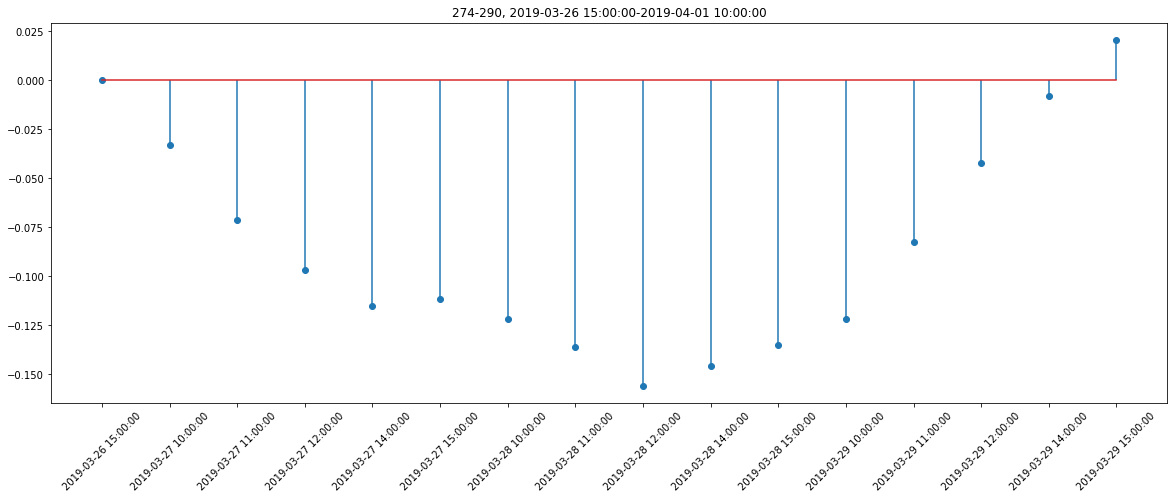

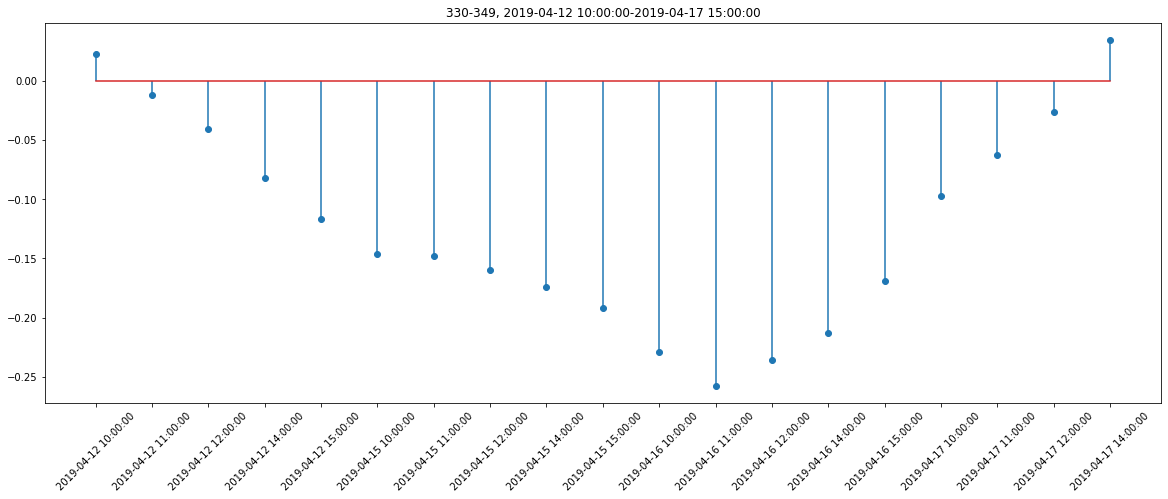

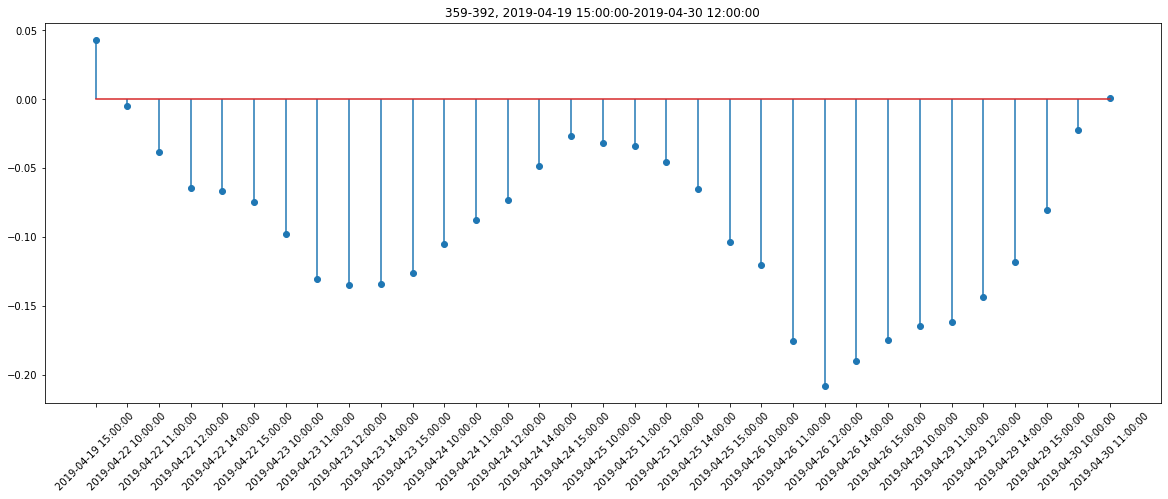

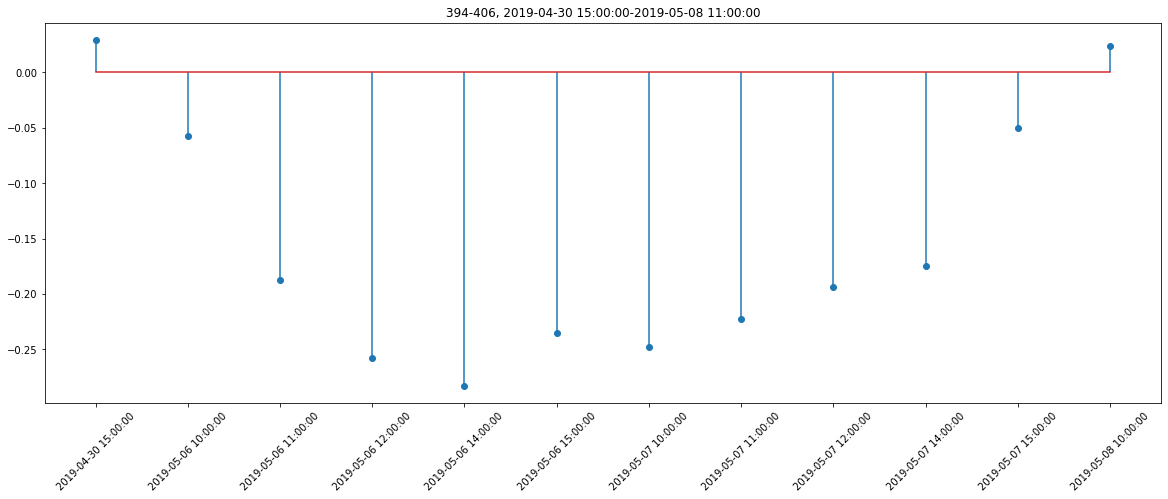

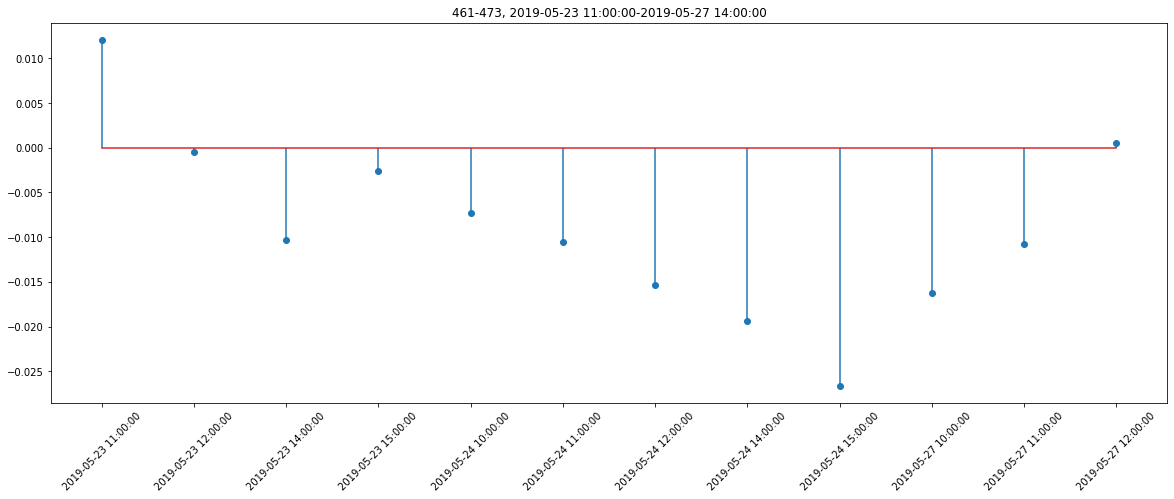

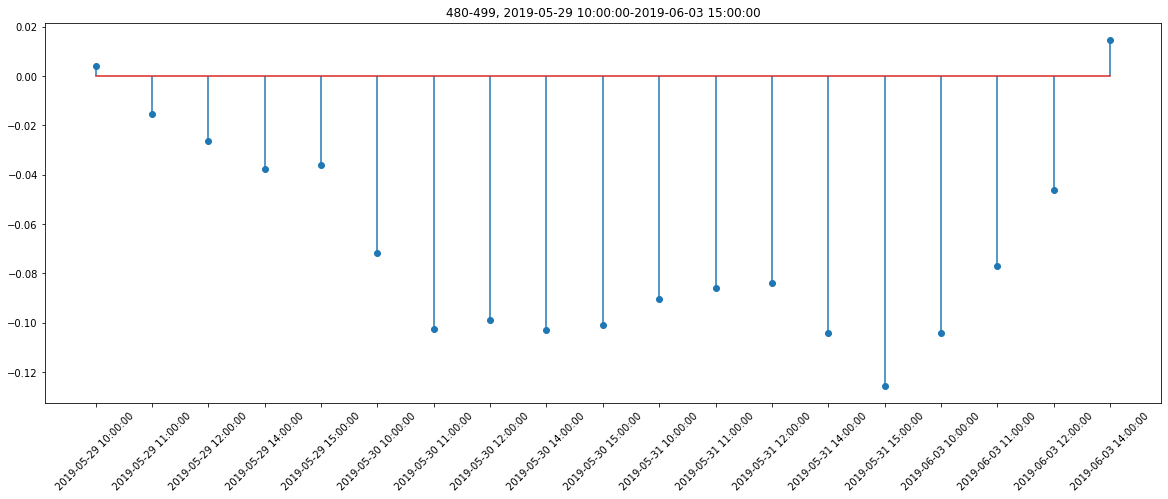

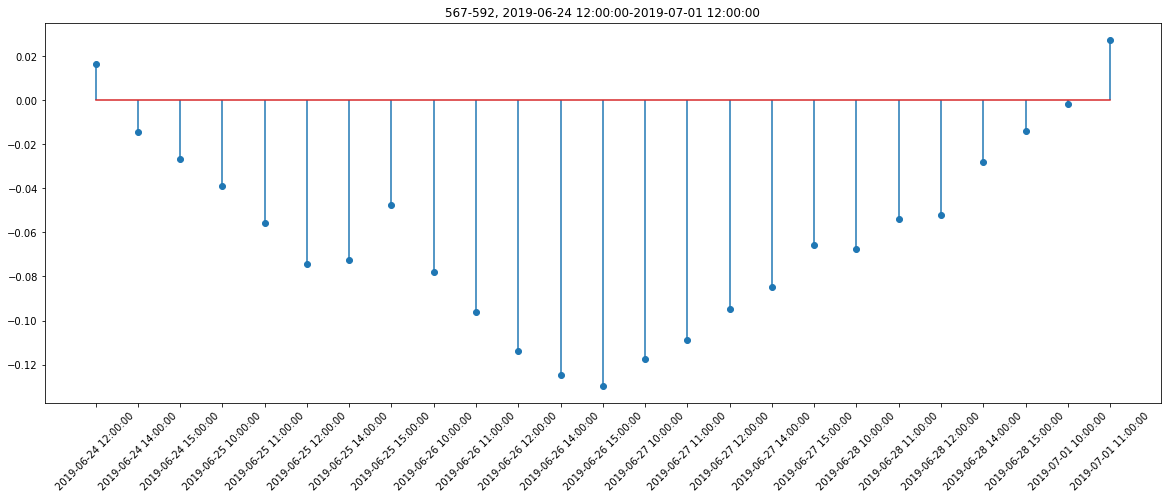

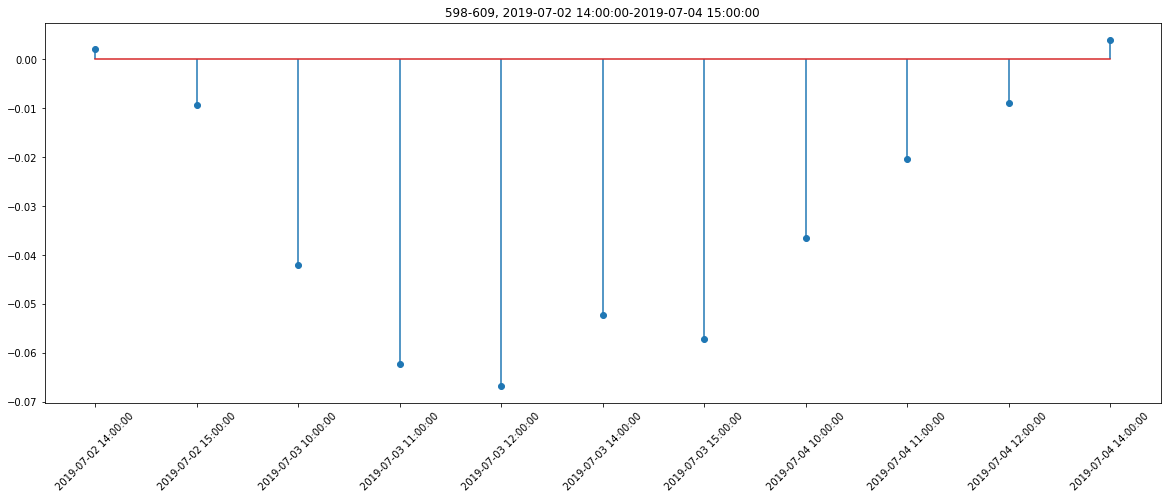

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
# fig, ax = plt.subplots(1,1, figsize=(20, 7))
# ax.stem(df[90:108].date, df[90:108].bar, use_line_collection=True)
# ax.xaxis.set_tick_params(rotation=45)

for s, e in blue_bar_2:
    #print(f"{s}\t{e}")
    start_i = s-1
    if start_i<0:
        start_i = 0
    end_i = e+2
    
    start_dt = df[start_i:start_i+1].date.values[0]
    end_dt = df[end_i:end_i+1].date.values[0]
    fig, ax = plt.subplots(1,1, figsize=(20, 7))
    ax.stem(df[start_i:end_i].date, df[start_i:end_i].bar, use_line_collection=True)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(f"{start_i}-{end_i}, {start_dt}-{end_dt}")
    

In [60]:
df[92:103].date
df[df.date=='2019-01-04 11:00:00']

11

In [115]:
## 统计一下这几个时间点进入之后，后面16个周期内最高点超过2%的

#先找处后面16周期最低、最高、当前open, close
# for s, e in blue_bar_2:
#     #print(f"{s}\t{e}")
#     start_i = max(0, s-1)
#     end_i = min(e+2, df.size)
    
#     start_dt = df[start_i:start_i+1].date.values[0]
#     end_dt = df[end_i:end_i+1].date.values[0]
    
tj_df = pd.DataFrame()

for date in buy_dates:
    #print(date)
    start_i = df[df.date==date].index[0]
    end_i = min(start_i+4*4, df.size)
    # 计算区间内的最大，最小值
    low = df[start_i:start_i+4].low.min()
    low_date = df[start_i:start_i+4][df.low==low].date.values[0]
    
    # 从low_date 到end_i
    low_date_i = df[df.date==low_date].index[0]
    
    hi = df[low_date_i:end_i].high.max() #一定是从最小值之后才有机会找最大的
    hi_date = df[low_date_i:end_i][df.high==hi].date.values[0]
    
    
    
    s = pd.DataFrame({"date":[date], "low":[low], "hi":[hi], "chg_pct":[round((hi-low)/low*100,3)], "low_date":[low_date], "hi_date":[hi_date]})
    tj_df= pd.concat([tj_df, s])
    
from datetime import datetime

tj_df['buy'] = tj_df.chg_pct.apply(lambda x: '✓' if x>=2 else "×")
# tj_df['real_low_date_delta'] = tj_df.low_date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))-tj_df.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
# tj_df['real_low_date_delta'] = tj_df.real_low_date_delta.apply(lambda x: x.seconds/3600)

tj_df


d:\program files\python3.7\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
d:\program files\python3.7\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,date,low,hi,chg_pct,low_date,hi_date,buy
0,2019-01-04 11:00:00,16.13,16.77,3.968,2019-01-04 11:00:00,2019-01-09 10:00:00,✓
0,2019-01-17 12:00:00,16.56,16.80,1.449,2019-01-18 10:00:00,2019-01-18 10:00:00,×
0,2019-01-23 14:00:00,16.19,16.57,2.347,2019-01-23 15:00:00,2019-01-25 10:00:00,✓
0,2019-01-29 14:00:00,16.05,16.40,2.181,2019-01-29 15:00:00,2019-01-31 11:00:00,✓
0,2019-02-18 11:00:00,16.51,16.80,1.757,2019-02-18 11:00:00,2019-02-20 15:00:00,×
0,2019-02-22 15:00:00,16.62,17.10,2.888,2019-02-22 15:00:00,2019-02-26 10:00:00,✓
0,2019-03-01 15:00:00,16.41,18.18,10.786,2019-03-01 15:00:00,2019-03-06 11:00:00,✓
0,2019-03-11 11:00:00,17.42,18.35,5.339,2019-03-11 11:00:00,2019-03-12 10:00:00,✓
0,2019-03-14 15:00:00,17.21,17.63,2.440,2019-03-14 15:00:00,2019-03-15 12:00:00,✓
0,2019-03-28 15:00:00,16.10,17.08,6.087,2019-03-29 10:00:00,2019-04-02 10:00:00,✓


In [119]:
st_df = pd.DataFrame({
    "e=1%":[tj_df[tj_df.chg_pct>=1].size/tj_df.size],
    "e=1.5%":[tj_df[tj_df.chg_pct>=1.5].size/tj_df.size],
    "e=2%":[tj_df[tj_df.chg_pct>=2].size/tj_df.size],
    "e=3%":[tj_df[tj_df.chg_pct>=3].size/tj_df.size],
})

st_df

,e=1%,e=1.5%,e=2%,e=3%
0,1.0,0.833333,0.777778,0.444444
